In [1]:
from random import random, uniform
from matplotlib import pyplot as plt
import numpy as np
import math
from tqdm import tqdm

In [2]:
from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [3]:
class Cube():
    #куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self, side=1, center=Point(0.5, 0.5, 0.5), ax3d=None):
        
        
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(a, a, 0) + vec
        self.D = Point(0, a, 0) + vec
        self.E = Point(0, 0, a) + vec
        self.F = Point(a, 0, a) + vec
        self.G = Point(a, a, a) + vec
        self.H = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F, self.G, self.H]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AD = Line(self.A, self.D)
        self.DC = Line(self.D, self.C)
        
        self.AE = Line(self.A, self.E)
        self.BF = Line(self.B, self.F)
        self.CG = Line(self.C, self.G)
        self.DH = Line(self.D, self.H)
        
        self.EF = Line(self.E, self.F)
        self.EH = Line(self.E, self.H)
        self.FG = Line(self.F, self.G)
        self.HG = Line(self.H, self.G)
        
        self.iterable_edges = [self.AB, self.BC, self.AD, self.DC, self.AE, self.BF,
                               self.CG, self.DH, self.EF, self.EH, self.FG, self.HG]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                # <3 Python's comparison operator
                self.A.x <= point.x <= self.G.x and
                self.A.y <= point.y <= self.G.y and
                self.A.z <= point.z <= self.G.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
        if intersections:
            polygon = [intersections.pop()]
            while intersections:
                last = polygon[-1]
                distances = [distance(last, x) for x in intersections]
                # We're only interested in the index of the next point,
                # this min function returns the minimum (index, distance)
                # tuple...
                successor = min(enumerate(distances), key=lambda x: x[1])
                # ...but we only need the index :)
                successor = successor[0]
                polygon.append(intersections.pop(successor))

            return polygon
        else:
            return []

In [4]:
def make_random_plane(n=10):
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(uniform(0, np.pi))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = Vector(center, Point(xm, ym, m1))
    
    if k2 >= 0:
        xn = 0
        yn = n
    else:
        xn = n
        yn = 0
        k2 = -k2
    m2 = n/2-2**(0.5)/2*n*k2
    v2 = Vector(center, Point(xn, yn, m2))
    
    #m1 и m2 - потенциальные минимумы
    
    if m1 <= m2:
        x = xm
        y = ym
        m = m1
    else:
        x = xn
        y = yn
        m = m2
    
    #генерируем "сдвиг"
    z = uniform(2*m - n, n)
    #возвращаем плоскость по точке и двум векторам
    return Plane(Point(x, y, z), v1, v2)

In [5]:
def make_3d_map(n=9, way_generate=make_random_plane):
    cube=Cube(side=n, center=Point(n/2, n/2, n/2))
    map_3d = np.zeros((n, n, n))

    plane = way_generate(n)
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                cube_n = Cube(side=1, center=Point(i+0.5, j+0.5, k+0.5))
                points_intersection = cube_n.intersection_with_plane(plane)
                if len(points_intersection) != 0:
                    map_3d[i, j, k] = 1
                
    return map_3d

In [6]:
def generate_3d_map_n_planes(n=9, n_planes=1000, way_generate=make_random_plane):
    map_3d = np.zeros((n, n, n))
    for i in tqdm(range(n_planes)):
        map_3d += make_3d_map(n=n, way_generate=way_generate)
    return map_3d

In [7]:
sec_way = generate_3d_map_n_planes(n=9, n_planes=1000, way_generate=make_random_plane)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:38<00:00,  1.73it/s]


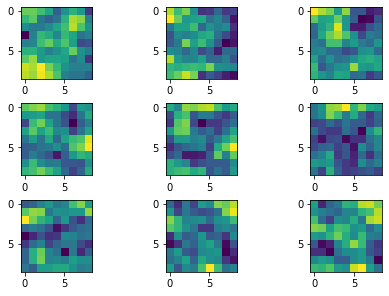

In [8]:
fig, axs = plt.subplots(3, 3, constrained_layout=True)

for i, ax in enumerate(axs.flat):
    ax.imshow(sec_way[i])

In [9]:
# это полная карта, а что если будем брать какой-то срез?

In [5]:
def points_to_line(x1, y1, x2, y2):
    if x1 != x2:
        k = (y2-y1)/(x2-x1)
        b = y1-k*x1
    return k, b

def intersect_line_map(k, b, n=10, n_line=100):
    #возвращает карту n на n с 0 и 1, 1 - если данный квадратик пересекает прямая y=kx+b
    eps = 0.000001
    map_2d_now = np.zeros((n, n))
    '''
    if k>0:
        mini = -b/k
        maxi = (n - b)/k
    elif k<0:
        mini = (n - b)/k
        maxi = -b/k
    '''
    mini=0
    maxi=n
    x_iter = np.linspace(max(0, mini), min(maxi, n) - eps, n_line)
    for x_n in x_iter:
        y_n = k*x_n+b
        if 0 <= y_n < n:
            i, j = math.floor(x_n), math.floor(y_n)
            map_2d_now[i][j] = 1
    return map_2d_now

def make_2d_map_srez(k=5, n=10, n_line=100, num_lines=100):
    #делает срез в кубике n на n на уровне k, num_lines - число плоскостей, секущих куб, возвращает карту n на n
    map_2d = np.zeros((n, n))
    #pl2 - срез
    pl2 = Plane(Point(0, 0, k), Vector(0, 0, 1))
    for i in range(num_lines):
        pl1 = make_random_plane(n=n)
        
        r, v = intersection(pl1, pl2).parametric()
        rx = r[0]
        ry = r[1]
        vx = v[0]
        vy = v[1]

        k = vy/vx
        b = ry - k*rx

        map_2d += intersect_line_map(k, b, n, n_line)
    print("std is ", np.std(map_2d))
    return map_2d/map_2d.sum()

def take_d_from_map_srez(k=5, n=10, n_line=100, num_lines=100):
    map_2d = np.zeros((n, n))
    #pl2 - срез
    pl2 = Plane(Point(0, 0, k), Vector(0, 0, 1))
    for i in range(num_lines):
        pl1 = make_random_plane(n=n)
        
        r, v = intersection(pl1, pl2).parametric()
        rx = r[0]
        ry = r[1]
        vx = v[0]
        vy = v[1]

        k = vy/vx
        b = ry - k*rx

        map_2d += intersect_line_map(k, b, n, n_line)
    return np.std(map_2d/map_2d.sum())

In [10]:
stds_small_small = []
for i in tqdm(range(100, 3000, 100)):
    stds_small_small.append(take_d_from_map_srez(k=3, n=10, n_line=1000, num_lines=i))

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:55<00:00,  1.91s/it]


In [11]:
stds_small = []
for i in tqdm(range(100, 25000, 2000)):
    stds_small.append(take_d_from_map_srez(k=3, n=10, n_line=1000, num_lines=i))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:09<00:00, 14.55s/it]


In [26]:
stds = []
for i in tqdm(range(1000, 50001, 5000)):
    stds.append(take_d_from_map_srez(k=3, n=100, n_line=1000, num_lines=i))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:48<00:00, 28.88s/it]


In [29]:
stds

[3.7946214924794954e-05,
 1.530778753891354e-05,
 1.1583058369747165e-05,
 9.561437564484526e-06,
 8.203579459665358e-06,
 7.574186729288618e-06,
 6.9273533196546215e-06,
 6.3638824609367605e-06,
 6.041580531573226e-06,
 5.667135332180842e-06]

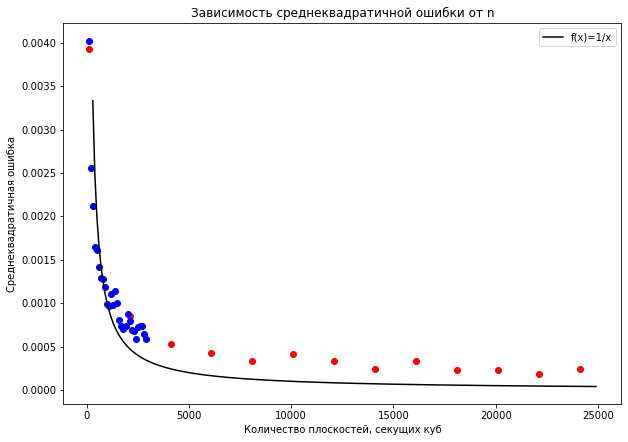

In [31]:
plt.figure(figsize=(10, 7))
x = np.array(range(300, 25000, 100))
#plt.plot(range(1000, 50001, 5000), stds, 'bo', color='green')
plt.plot(range(100, 25000, 2000), stds_small, 'bo', color='red')
plt.plot(range(100, 3000, 100), stds_small_small, 'bo', color='blue')
plt.plot(x, 1/x, color='black', label='f(x)=1/x')

plt.xlabel('Количество плоскостей, секущих куб')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('Зависимость среднеквадратичной ошибки от n')
plt.legend()
plt.savefig('куб_срез_ошибка.jpg')
plt.show()

std is  8.045731806989343


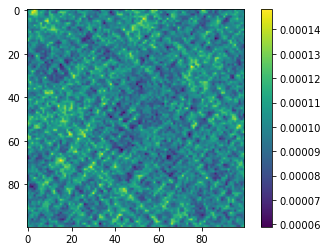

Wall time: 15.2 s


In [54]:
%%time
plt.imshow(make_2d_map_srez(k=5, n=100, n_line=1000, num_lines=10000))
plt.colorbar()
plt.show()

std is  8.088117148014115


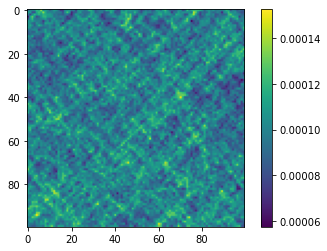

Wall time: 15.1 s


In [55]:
%%time
plt.imshow(make_2d_map_srez(k=4, n=100, n_line=1000, num_lines=10000))
plt.colorbar()
plt.show()

std is  8.104155178672235


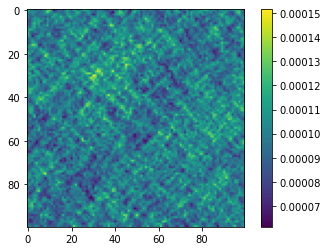

Wall time: 12.4 s


In [56]:
%%time
plt.imshow(make_2d_map_srez(k=2, n=100, n_line=1000, num_lines=10000))
plt.colorbar()
plt.show()

std is  8.005335210970244


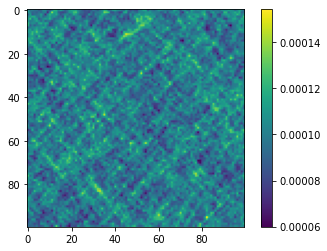

Wall time: 15.4 s


In [57]:
%%time
plt.imshow(make_2d_map_srez(k=0.1, n=100, n_line=1000, num_lines=10000))
plt.colorbar()
plt.show()

std is  7.872535789058059


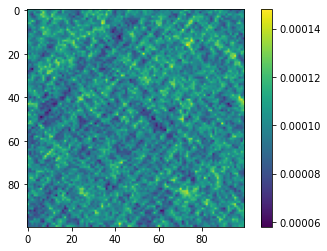

Wall time: 15.5 s


In [58]:
%%time
plt.imshow(make_2d_map_srez(k=0.01, n=100, n_line=1000, num_lines=10000))
plt.colorbar()
plt.show()

In [65]:
def make_random_plane_2(n=10):
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(np.arcsin(uniform(-1,1)))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = 

In [66]:
def make_2d_map_srez_sin(k=5, n=10, n_line=100, num_lines=100):
    '''
    Генерируем угол и сдвиг
    '''
    map_2d = np.zeros((n, n))
    #pl2 - срез
    pl2 = Plane(Point(0, 0, k), Vector(0, 0, 1))
    for i in range(num_lines):
        pl1 = make_random_plane_2(n=n)
        
        r, v = intersection(pl1, pl2).parametric()
        rx = r[0]
        ry = r[1]
        vx = v[0]
        vy = v[1]

        k = vy/vx
        b = ry - k*rx

        map_2d += intersect_line_map(k, b, n, n_line)
    print("std is ", np.std(map_2d))
    return map_2d/map_2d.sum()

std is  0.8319208556106765


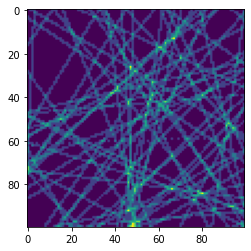

In [70]:
plt.imshow(make_2d_map_srez_sin(k=0.3, n=100, n_line=1000, num_lines=100))

std is  7.665526789464636


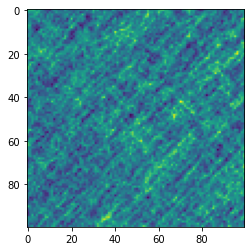

In [71]:
plt.imshow(make_2d_map_srez_sin(k=5, n=100, n_line=1000, num_lines=10000))

In [6]:
def make_random_plane_3_into_sphere_1(r=1.8, center=Point(0.5, 0.5, 0.5)):
    #генерируем плоскость по вектору нормали и свигу вдоль этой нормали
    # r - радиус сдвига (шара который замощают)
    # center - координаты центра
    fi = uniform(0, 2*np.pi)
    teta = uniform(0, 2*np.pi) #пока так
    n = Vector(r*np.sin(teta)*np.cos(fi), 
               r*np.sin(teta)*np.sin(fi),
               r*np.cos(teta))
    alpha = uniform(-1, 1)
    point = Point(alpha*n[0]+center[0], alpha*n[1]+center[1], alpha*n[2]+center[2])
    return Plane(point, n)

def make_random_plane_3_into_sphere_arcsin(r=1.8, center=Point(0.5, 0.5, 0.5)):
    #генерируем плоскость по вектору нормали и свигу вдоль этой нормали
    # r - радиус сдвига (шара который замощают)
    # center - координаты центра
    fi = uniform(0, 2*np.pi)
    teta = np.arcsin(uniform(-1, 1)) #пока так
    n = Vector(r*np.sin(teta)*np.cos(fi), 
               r*np.sin(teta)*np.sin(fi),
               r*np.cos(teta))
    alpha = uniform(-1, 1)
    point = Point(alpha*n[0]+center[0], alpha*n[1]+center[1], alpha*n[2]+center[2])
    return Plane(point, n)

In [7]:
def make_2d_map_srez_sphere_1(k=0.5, n=1, n_line=100, num_lines=100):
    map_2d = np.zeros((n, n))
    #pl2 - срез
    pl2 = Plane(Point(0, 0, k), Vector(0, 0, 1))
    for i in range(num_lines):
        #генерируем плоскость радиуса sqrt(3)/2*n, c с центром в середеине куба со сторонами n
        pl1 = make_random_plane_3_into_sphere_1(r=1.74/2*n, center=Point(n/2, n/2, n/2))
        
        r, v = intersection(pl1, pl2).parametric()
        rx = r[0]
        ry = r[1]
        vx = v[0]
        vy = v[1]

        k = vy/vx
        b = ry - k*rx

        map_2d += intersect_line_map(k, b, n, n_line)
    print("std is ", np.std(map_2d/map_2d.sum()))
    return map_2d/map_2d.sum()

def make_2d_map_srez_sphere_arcsin(k=0.5, n=1, n_line=100, num_lines=100):
    map_2d = np.zeros((n, n))
    #pl2 - срез
    pl2 = Plane(Point(0, 0, k), Vector(0, 0, 1))
    for i in range(num_lines):
        #генерируем плоскость радиуса sqrt(3)/2*n, c с центром в середеине куба со сторонами n
        pl1 = make_random_plane_3_into_sphere_arcsin(r=1.74/2*n, center=Point(n/2, n/2, n/2))
        
        r, v = intersection(pl1, pl2).parametric()
        rx = r[0]
        ry = r[1]
        vx = v[0]
        vy = v[1]

        k = vy/vx
        b = ry - k*rx

        map_2d += intersect_line_map(k, b, n, n_line)
    print("std is ", np.std(map_2d/map_2d.sum()))
    return map_2d/map_2d.sum()

std is  1.544108322017576e-05


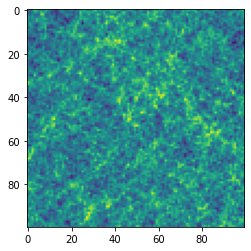

In [10]:
plt.imshow(make_2d_map_srez_sphere_1(k=6, n=100, n_line=1000, num_lines=10000))
plt.show()

std is  1.7297596243022583e-05


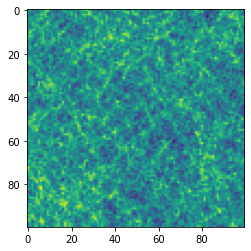

In [9]:
plt.imshow(make_2d_map_srez_sphere_arcsin(k=6, n=100, n_line=1000, num_lines=10000))
plt.show()

In [ ]:
plt.imshow(make_2d_map_srez_sphere_arcsin(k=0.3, n=100, n_line=1000, num_lines=10000))